In [1]:
!pip install pygame
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827647 sha256=b1aac693290a539c307386034d1707e74f3a713a80c65b561284305244150428
  Stored in directory: /root/.cache/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode
from collections import namedtuple, deque
from itertools import count
import torch.optim as optim

from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
gym.__version__

'0.26.2'

In [3]:
env = gym.make('CartPole-v1', render_mode = "rgb_array")

In [ ]:
state, info = env.reset()
env.action_space.sample()
print(state)
print(info)

[ 0.03254451  0.01187301  0.00847553 -0.01619112]
{}


In [4]:
!nvidia-smi

Mon Apr  3 10:37:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
memory = deque([], maxlen=100)
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
memory.append(Transition([[-0.0100, -0.9375,  0.0757,  1.5141]], [[0]], [[-0.0100, -0.9375,  0.0757,  1.5141]], [1.]))
memory

deque([Transition(state=[[-0.01, -0.9375, 0.0757, 1.5141]], action=[[0]], next_state=[[-0.01, -0.9375, 0.0757, 1.5141]], reward=[1.0])])

In [6]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [46]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
print(env.action_space)
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, is_test):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or is_test==True:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


Discrete(2)


In [ ]:
transitions = memory.sample(2)
transitions = Transition(*zip(*transitions))
torch.cat(transitions.action)

tensor([[1],
        [0]], device='cuda:0')

In [ ]:
transitions = memory.sample(2)
transitions = Transition(*zip(*transitions))
print(transitions)
transitions = list(transitions.next_state)
transitions[0] = None
tuple(map(lambda s: s is not None,transitions))

Transition(state=(tensor([[ 0.0910,  0.9333,  0.0510, -0.8398]], device='cuda:0'), tensor([[ 0.1431,  0.7367,  0.0073, -0.5132]], device='cuda:0')), action=(tensor([[0]], device='cuda:0'), tensor([[1]], device='cuda:0')), next_state=(tensor([[ 0.1097,  0.7375,  0.0342, -0.5315]], device='cuda:0'), tensor([[ 0.1578,  0.9317, -0.0030, -0.8036]], device='cuda:0')), reward=(tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0')))


(False, True)

In [47]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # 1 is column, action_batch is index
    # get the state_action_value
    # https://zhuanlan.zhihu.com/p/352877584
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final. 0 is value, 1 is indices
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    #double-DQN
    with torch.no_grad():
        non_final_next_state_action_batch = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, non_final_next_state_action_batch).flatten()

    #DQN
    # with torch.no_grad():
    #     next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]


    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [48]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 50

reward_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    temp_reward = 0
    for t in count():
        action = select_action(state, False)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        temp_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            reward_list.append(temp_reward)
            if(i_episode+1)%10 == 0:
                print(f'已经完成{i_episode+1}代')
            break


print('Complete')

已经完成10代
已经完成20代
已经完成30代
已经完成40代
已经完成50代
已经完成60代
已经完成70代
已经完成80代
已经完成90代
已经完成100代
已经完成110代
已经完成120代
已经完成130代
已经完成140代
已经完成150代
已经完成160代
已经完成170代
已经完成180代
已经完成190代
已经完成200代
已经完成210代
已经完成220代
已经完成230代
已经完成240代
已经完成250代
已经完成260代
已经完成270代
已经完成280代
已经完成290代
已经完成300代
已经完成310代
已经完成320代
已经完成330代
已经完成340代
已经完成350代
已经完成360代
已经完成370代
已经完成380代
已经完成390代
已经完成400代
已经完成410代
已经完成420代
已经完成430代
已经完成440代
已经完成450代
已经完成460代
已经完成470代
已经完成480代
已经完成490代
已经完成500代
Complete


In [49]:
def draw_pic(x, y, path):
    plt.plot(x, y)
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.savefig(path)

In [23]:
print(len(reward_list))

60


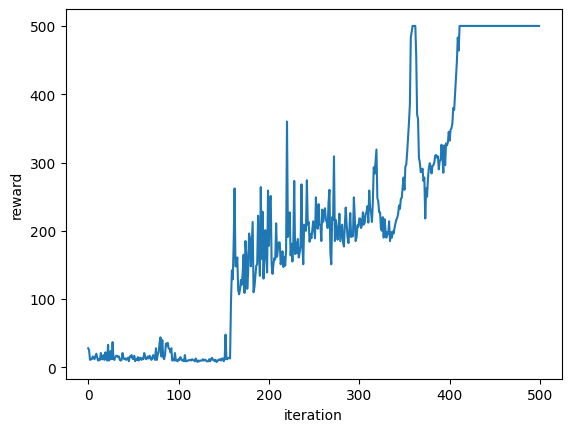

In [50]:
draw_pic(range(len(reward_list)), reward_list, "iteration-sumReward")

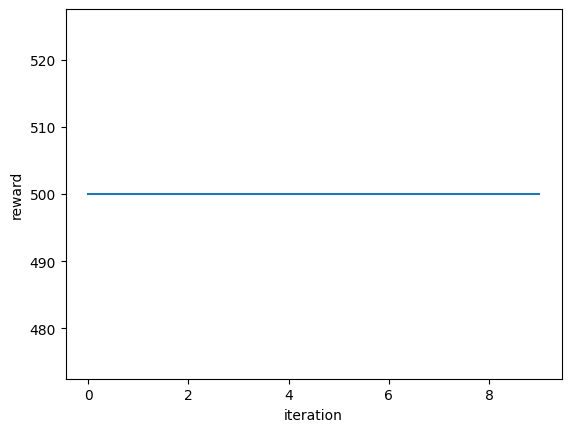

In [51]:
#test
test_reward_list = []
for i in range(10):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    temp_reward = 0
    for t in count():
        action = select_action(state, True)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        temp_reward += reward
        done = terminated or truncated
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        if done:
            test_reward_list.append(temp_reward)
            break
draw_pic(range(len(test_reward_list)), test_reward_list, "iteration-sumReward-test")